In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_style('white')

There exist multiple penguin species throughout Antarctica, including the Adelie, Chinstrap, and Gentoo. When encountering one of these penguins on an Antarctic trip, we might classify its species
$$
Y= \begin{cases}A & \text { Adelie } \\ C & \text { Chinstrap } \\ G & \text { Gentoo }\end{cases}
$$
by examining various physical characteristics, such as whether the penguin weighs more than the average $4200 \mathrm{~g}$,
$$
X_1= \begin{cases}1 & \text { above-average weight } \\ 0 & \text { below-average weight }\end{cases}
$$
as well as measurements of the penguin's bill
$$
\begin{aligned}
& X_2=\text { bill length }(\text { in } \mathrm{mm}) \\
& X_3=\text { flipper length }(\text { in } \mathrm{mm})
\end{aligned}
$$
The penguins_bayes data, originally made available by Gorman, Williams, and Fraser (2014) and distributed by Horst, Hill, and Gorman (2020), contains the above species and feature information for a sample of 344 Antarctic penguins:

In [3]:
penguins = sns.load_dataset('penguins')
display(penguins.head())
display(penguins.info())
display(penguins.describe())

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


None

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Among these penguins, 152 are Adelies, 68 are Chinstraps, and 124 are Gentoos. We’ll assume throughout that the proportional breakdown of these species in our dataset reflects the species breakdown in the wild. That is, our prior assumption about any new penguin is that it’s most likely an Adelie and least likely a Chinstrap:

In [4]:
display(penguins['species'].value_counts(normalize=False))
display(penguins['species'].value_counts(normalize=True))

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

Adelie       0.441860
Gentoo       0.360465
Chinstrap    0.197674
Name: species, dtype: float64

We drop `sex` column for simplicity as there are quite a few missing values in it.

In [5]:
penguins = penguins.drop(columns=["sex"], inplace=False).reset_index(drop=True)

We also drop the other NA rows, there are only 2 of them.

In [6]:
penguins = penguins.dropna().reset_index(drop=True) # drop rows with NAs, only 2 rows
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0
...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214.0,4925.0
338,Gentoo,Biscoe,46.8,14.3,215.0,4850.0
339,Gentoo,Biscoe,50.4,15.7,222.0,5750.0
340,Gentoo,Biscoe,45.2,14.8,212.0,5200.0


In [7]:
display(penguins['species'].value_counts(normalize=False))
display(penguins['species'].value_counts(normalize=True))

Adelie       151
Gentoo       123
Chinstrap     68
Name: species, dtype: int64

Adelie       0.441520
Gentoo       0.359649
Chinstrap    0.198830
Name: species, dtype: float64

In [8]:
print(f"The mean body mass of penguins is {penguins['body_mass_g'].mean():.2f} grams.")

The mean body mass of penguins is 4201.75 grams.


We create a new categorical feature `overweight` which is 1 if the `body_mass_g` is over the 
mean, and 0 otherwise. This feature corresponds to our earlier defined random variable $X_1$.

In [9]:
penguins["overweight"] = (penguins["body_mass_g"] > penguins["body_mass_g"].mean()).astype(int)
display(penguins["overweight"].value_counts())

0    193
1    149
Name: overweight, dtype: int64

## The Prior

The prior distribution for $Y$ is a categorical distribution with three categories, one for each species. The prior probabilities are given by the relative frequencies of each species in the dataset:

$$
\begin{aligned}
& \text { A } \sim \text { Categorical }(\pi_A=0.44) \\
& \text { C } \sim \text { Categorical }(\pi_C=0.20) \\
& \text { G } \sim \text { Categorical }(\pi_G=0.36)
\end{aligned}
$$

which implies

$$
\begin{aligned}
\mathbb{P}(Y=A) &= 0.44 \\
\mathbb{P}(Y=C) &= 0.20 \\
\mathbb{P}(Y=G) &= 0.36
\end{aligned}
$$

Given a new penguin not in the dataset, the **prior assumption** says that the probability 
of it being an Adelie is $0.44$, the probability of it being a Chinstrap is $0.20$, and the probability of it being a Gentoo is $0.36$. 

Reference: [The Bayes Rules Book](https://www.bayesrulesbook.com/chapter-2.html#building-a-bayesian-model-for-events).

## Classifying one penguin

Consider a new penguin with the following features:

- `body_mass_g`: $< 4200 \mathrm{~g}$
- `bill_length_mm`: $50 \mathrm{~mm}$
- `flipper_length_mm`: $195 \mathrm{~mm}$

Then we want to find out the posterior distribution of the species of this penguin, given the features. 
In other words, what is the probability of this penguin being an Adelie, Chinstrap, or Gentoo, given the features?

### One Categorical Feature

Let's start with the first feature, `body_mass_g` and since the penguin weights less than the average weight of $4200 \mathrm{~g}$, it belongs to the category $0$ of the feature `overweight`.

In [10]:
total = penguins.groupby("species").size().reset_index(name="counts")
display(total)

overweight = (
    penguins[penguins["overweight"] == 1]
    .groupby("species")["overweight"]
    .sum()
    .reset_index()
)
display(overweight)

overweight["overweight"] = [
    i / j * 100 for i, j in zip(overweight["overweight"], total["counts"])
]
total["counts"] = [i / j * 100 for i, j in zip(total["counts"], total["counts"])]

display(total)
display(overweight)  # percentage of overweight penguins for each species

,species,counts
0,Adelie,151
1,Chinstrap,68
2,Gentoo,123


,species,overweight
0,Adelie,25
1,Chinstrap,7
2,Gentoo,117


,species,counts
0,Adelie,100.0
1,Chinstrap,100.0
2,Gentoo,100.0


,species,overweight
0,Adelie,16.556291
1,Chinstrap,10.294118
2,Gentoo,95.121951


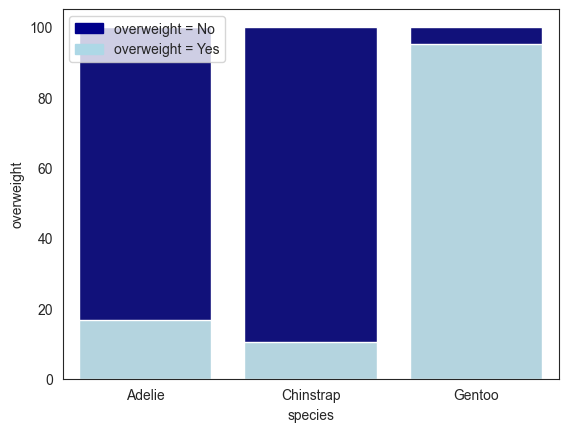

In [11]:
# bar chart 1 -> top bars (group of 'overweight=No')
bar1 = sns.barplot(x="species", y="counts", data=total, color="darkblue")

# bar chart 2 -> bottom bars (group of 'overweight=Yes')
bar2 = sns.barplot(x="species", y="overweight", data=overweight, color="lightblue")

# add legend
top_bar = mpatches.Patch(color="darkblue", label="overweight = No")
bottom_bar = mpatches.Patch(color="lightblue", label="overweight = Yes")
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

Before we do anything, we are given one categorical variable and for this penguin, it falls under
category $0$ of the `overweight` feature (i.e. underweight).

From the conditionals below, the Chinstrap species have the highest probability of underweight penguins by
the relative freqeuncy table. That is, for each species, we compute the relative frequency within each species as 

$$
\begin{aligned}
\mathbb{P}[X_1=0|Y=A] &= 0.8344 \\
\mathbb{P}[X_1=0|Y=C] &= 0.8971 \\
\mathbb{P}[X_1=0|Y=G] &= 0.0488 \\
\end{aligned}
$$

Note that we are abusing the notation $\mathbb{P}$ here, since we are not talking about the probability of a random variable, but rather the relative frequency of a feature within a species.
Also note the above expressions is the conditional probability of $X_1=0$ given $Y$ is a certain species, also termed as the **likelihood** of $Y$ being a certain species given $X_1=0$. Again, we are being loose with notation here as everything here is empirical!

So one might say that the Chinstrap species is the least likely to be overweight, and the Gentoo species is the most likely to be overweight. Well, this makes intuitive sense since we are talking
about "likelihood" here: of all $P(X_1=0|Y=A)$, $P(X_0=1|Y=C)$, and $P(X_1=0|Y=G)$, the Chinstrap species is the least likely to be overweight.

Yet before we can make any conclusions, we need to take into account the prior probabilities of each species. We should weight the relative frequencies by the prior probabilities of each species. Intuitively, since Chinstrap is also the ***rarest*** species, it diminishes the likelihood of the penguin being a Chinstrap.

We need to use both the prior and the likelihood to compute the posterior distribution of the species of the penguin. The posterior distribution is the probability of the species of the penguin given the features.

$$
\begin{aligned}
\mathbb{P}[Y=y|X_1=x_1] = \frac{\mathbb{P}[X_1=x_1|Y=y] \mathbb{P}[Y=y]}{\mathbb{P}[X_1=x_1]}
\end{aligned}
$$

For example, if our given feature of the test penguin is $X_1=0$, then we need
to find the posterior distribution of **all** species given $X_1=0$. That is, we need to compute

$$
\begin{aligned}
\mathbb{P}[Y=A|X_1=0] &= \frac{\mathbb{P}[X_1=0|Y=A] \mathbb{P}[Y=A]}{\mathbb{P}[X_1=0]} \\
\mathbb{P}[Y=C|X_1=0] &= \frac{\mathbb{P}[X_1=0|Y=C] \mathbb{P}[Y=C]}{\mathbb{P}[X_1=0]} \\
\mathbb{P}[Y=G|X_1=0] &= \frac{\mathbb{P}[X_1=0|Y=G] \mathbb{P}[Y=G]}{\mathbb{P}[X_1=0]}
\end{aligned}
$$

and get the **argmax** of the above three expressions. The argmax is the species with the highest probability.
Note this makes sense because $\mathbb{P}[Y=y|X_1=x_1]$ is a legitimate probability measure, since it sums to $1$.

The **argmax** expression is as follows:

$$
\begin{aligned}
\text{argmax}_{y \in \{A, C, G\}} \mathbb{P}[Y=y|X_1=0] &= \text{argmax}_{y \in \{A, C, G\}} \frac{\mathbb{P}[X_1=0|Y=y] \mathbb{P}[Y=y]}{\mathbb{P}[X_1=0]} \\
&= \text{argmax}_{y \in \{A, C, G\}} \frac{\mathbb{P}[X_1=0|Y=y] \mathbb{P}[Y=y]}{\sum_{y' \in \{A, C, G\}} \mathbb{P}[X_1=0|Y=y'] \mathbb{P}[Y=y']}
\end{aligned}
$$

Often times, it is better to see it in terms of the probability density function (PDF), since
we are talking about conditional probabilities of a random variable. The PDF of the posterior distribution is

$$
\begin{aligned}
f_{Y|X_1}(y|x_1) = \frac{f_{X_1|Y}(x_1|y) f_{Y}(y)}{f_{X_1}(x_1)}
\end{aligned}
$$

Again, we assume that PDF and PMF are the same thing.


The table below breaks down the joint distribution table of $Y$ and $X_1$, since
both are categorical, it is easy to compute the joint distribution table.

| $Y$ | $X_1 = 0$ | $X_1 = 1$ | $\sum$ |
| --- | --- | --- | --- |
| A | 126 | 25 | 151 |
| C | 61 | 7 | 68 |
| G | 6 | 117 | 123 |
| $\sum$ | 193 | 149 | 342 |


| $Y$ | $X_1 = 0$ | $X_1 = 1$ | $\sum$ |
| --- | --- | --- | --- |
| A | 0.365 | 0.072 | 0.437 |
| C | 0.178 | 0.020 | 0.198 |
| G | 0.017 | 0.342 | 0.359 |
| $\sum$ | 0.560 | 0.434 | 1.000 |



The image is a sketch of the joint distribution table of $Y$ and $X_1$.

<img src="../assets/penguin_overweight_joint.jpg" alt="alt text" height="500"/>

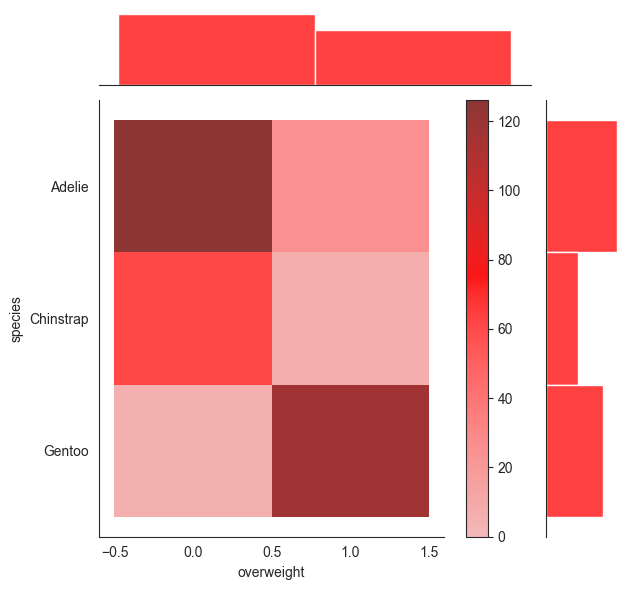

In [12]:
g = sns.JointGrid(data=penguins, x="overweight", y="species")
low, high = 0, 1
# bins =  np.arange(0, high + 1.5) - 0.5 # [-0.5, 0.5, 1.5]
g.plot_joint(sns.histplot,discrete=True, cbar=True, color="red")
g.plot_marginals(sns.histplot, discrete=True, color="red");

We can also use seaborns `jointgrid` to do a joint distribution plot, the darker tone of red
corresponds to a higher impulse of the joint distribution.

Indeed we can see that Adelie + overweight = 0 and Gentoo + overweight = 1 are the
most red tone, indicating that $\mathbb{P}[X_1=0, Y=A]$ and $\mathbb{P}[X_1=1, Y=G]$ are the highest
impulses of the joint distribution.

In our table they correspond to 0.365 and 0.342 respectively.

The top and right are the marginal distribution of $Y$ and $X_1$ respectively. They are
just relative frequencies.

Note the above all uses histo plot as default, where we used normal histograms to
"estimate" the PDF of the joint distribution. We can also use a kernel density estimation (KDE) to
do so, which is a bit more smooth and accurate. Note everything here is JUST an estimation. We will
use it in continuous distributions later.

To see the empirical conditional distribution of $X_1=0$ given $Y=C$ for example,
it is simply given by the table above. To calculate we ask ourselves the following question:

what is $P(X_1=0|Y=C)$? We simply look at the table EARLIER and see that it is $0.8971$. But to 
read it off this joint distribution table, you first need to recognize that when $Y=C$, we have shrinked our table to only the rows where $Y=C$ (2nd row). Then we look at the column where $X_1=0$ and see that it is 61, then we divide by the sum of the row, which is 68, to get $0.8971$.

In this scenario, the author mentioned that we can actually directly compute the posterior probability from the empirical joint distribution table.

For example, if we want to calculate the posterior probability of $Y=A$ given $X_1=0$, 
we simply look at the column $X_1=0$ and calculate the relative frequency of $Y=A$,

$$
\mathbb{P}[Y=A|X_1=0] = \frac{126}{193} = 0.652
$$

or equivalently

$$
\mathbb{P}[Y=A|X_1=0] = \frac{0.365}{0.560} = 0.652
$$

Note that we are still talking about empirical here, so nothing is really proven yet.

In a similar fashion, we have

$$
\mathbb{P}[Y=C|X_1=0] = \frac{61}{193} = 0.315
$$


$$
\mathbb{P}[Y=G|X_1=0] = \frac{6}{193} = 0.031
$$


We can confirm this by computing the posterior distribution using the formula above.

Firstly, our prior says that

$$
\begin{aligned}
\mathbb{P}[Y=A] &= \frac{151}{342} = 0.4415 \\
\mathbb{P}[Y=C] &= \frac{68}{342} = 0.1988 \\
\mathbb{P}[Y=G] &= \frac{123}{342} = 0.3596 \\
\end{aligned}
$$

These values will handle the $\mathbb{P}[Y=y]$ term in the formula above.
I have to emphasize again that all of these are empirical probabilities, the actual
probability of the species of the penguin is not known, i.e $\mathbb{P}[Y=y]$ is not known
but we can reasonably estimate it using statistics, and in this case we estimate
it using the relative frequency of each species, we will see later that the
relative frequency is a good estimator of the actual probability by Maximum Likelihood Estimation.

Next, we find the likelihood terms of $\mathbb{P}[X_1=0|Y=y]$ for each species $y$. 

$$
\begin{aligned}
\mathbb{P}[X_1=0|Y=A] &= \frac{126}{151} = 0.8344 \\
\mathbb{P}[X_1=0|Y=C] &= \frac{61}{68} = 0.8971 \\
\mathbb{P}[X_1=0|Y=G] &= \frac{6}{123} = 0.0488 \\
\end{aligned}
$$

Again, these are empirical probabilities, we are not sure if these are the actual probabilities of the features given the species, but we can reasonably estimate it using statistics, and
in this case we again use relative frequency to estimate it. We will see later this is modelled
by the Multinomial distribution with parameter $\pi_y$.

See WIKIPEDIA: When k is 2 and n is 1, the multinomial distribution is the Bernoulli distribution. When k is 2 and n is bigger than 1, it is the binomial distribution. When k is bigger than 2 and n is 1, it is the categorical distribution.



Plugging these **priors** and **likelihoods** into the formula above, we get the 
denominator, the normalizing constant, which is

$$
\begin{aligned}
\mathbb{P}[X_1=0] &= \mathbb{P}[X_1=0|Y=A] \mathbb{P}[Y=A] \\
&+ \mathbb{P}[X_1=0|Y=C] \mathbb{P}[Y=C] \\
&+ \mathbb{P}[X_1=0|Y=G] \mathbb{P}[Y=G] \\
&= \dfrac{193}{342} = 0.565
\end{aligned}
$$


We pause a while to note that $\mathbb{P}[X_1]$ is the probability of observing $X_1=x_1$,
which is independent of $Y$, so we can compute it using the law of total probability. 

Of course, this is also merely the relative frequency of $X_1=0$ in the dataset, which is expected
by intuition, but we will never know the actual probability of $X_1=0$. We can also
estimate it using Binomial distribution if we assume that it is a Bernoulli process, but
if it is continuous, then it is often harder to estimate it. We will see later that
we can omit the denominator since it is "constant" for all $Y$.


Finally, by Bayes' rule, we get the posterior probability of $Y=A$ given $X_1=0$,

$$
\begin{aligned}
\mathbb{P}[Y=A|X_1=0] &= \dfrac{\mathbb{P}[X_1=0|Y=A] \mathbb{P}[Y=A]}{\mathbb{P}[X_1=0]} \\
&= \dfrac{151/342 \times 126/151}{193/342} \\
&= \dfrac{126}{193} = 0.6528
\end{aligned}
$$

which is the same as the one we calculated earlier using the empirical joint distribution table.

In a similar fashion, we get the posterior probability of $Y=C$ given $X_1=0$, and $Y=G$ given $X_1=0$.

$$
\begin{aligned}
\mathbb{P}[Y=C|X_1=0] &= \dfrac{68/342 \times 61/68}{193/342} = \dfrac{61}{193} = 0.3161 \\
\mathbb{P}[Y=G|X_1=0] &= \dfrac{123/342 \times 6/123}{193/342} = \dfrac{6}{193} = 0.0311
\end{aligned}
$$

And the argmax of these three posterior probabilities is $Y=A$, so we predict that the penguin is of species $A$.
We observe that to get the argmax, we do not need the denominator, because it is the same for all $Y$.

So we can omit the denominator, and we get the same result, it may no longer sum to 1, but 
it does not affect the final result.

We also saw here that if our prior is very low, then even though the likelihood is high, the posterior can still be
low if `prior << likelihood`. This is the reason why we need to use prior knowledge to help us make better predictions.

### One Quantitative Predictor

We now ignore the earlier categorical predictor $X_1$ and focus on the quantitative predictor $X_2$.
This penguin has a `bill_length_mm` of 50mm, so we want to predict the species of the penguin given this information.

We know that as we move on to continuous space, we can no longer use "relative frequency" to estimate the probability of a continuous variable happening, as we will see later.

Let's do some EDA.

In [13]:
bill_length_mm = penguins[['bill_length_mm', 'species']]
bill_length_mm

,bill_length_mm,species
0,39.1,Adelie
1,39.5,Adelie
2,40.3,Adelie
3,36.7,Adelie
4,39.3,Adelie
...,...,...
337,47.2,Gentoo
338,46.8,Gentoo
339,50.4,Gentoo
340,45.2,Gentoo


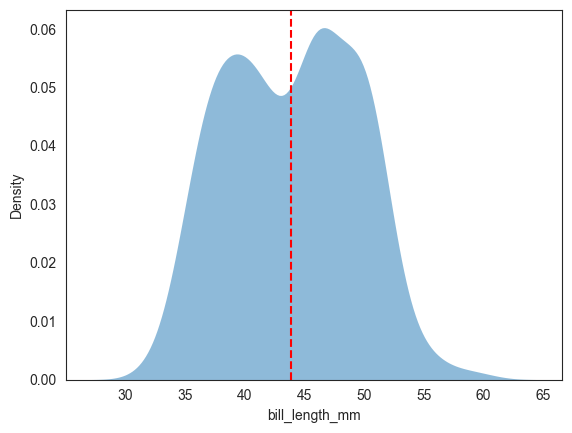

In [14]:
# plotting both distibutions on the same figure
_ = sns.kdeplot(data=penguins, x="bill_length_mm", fill=True, common_norm=False, alpha=.5, linewidth=0, legend=True)
# plot vertical line 
_ = plt.axvline(x=penguins["bill_length_mm"].mean(), color='red', linestyle='--')
# plt.legend()
plt.show();

The kdeplot above is for an univariate, empirical estimation of the whole dataset, not
conditional on any class label.

To see the conditional distribution, we can use the `hue` parameter in `seaborn.kdeplot` to plot the conditional distribution of $X_2$ given $Y=y$. You just imagine that given
say Adelie has happened, then we zoom into the reduced sample space of Adelie, and plot the distribution of $X_2$ in this **reduced sample space**. Things get a bit more complicated when we have more than one predictor, but the idea is the same, we will see later as well.

I want to emphasize that for 1 predictor conditioned on another random variable,
in this case $X_2$ conditioned on $Y$, the conditional distribution is a **marginal distribution**,
or we can view it as **univariate distribution**. This is because once we $Y=y$ has happened,
there is no randomness left in $Y$, we are only looking at the distribution of $X_2$ in the reduced sample space $\mathcal{\Omega}_{X_2|Y}$.

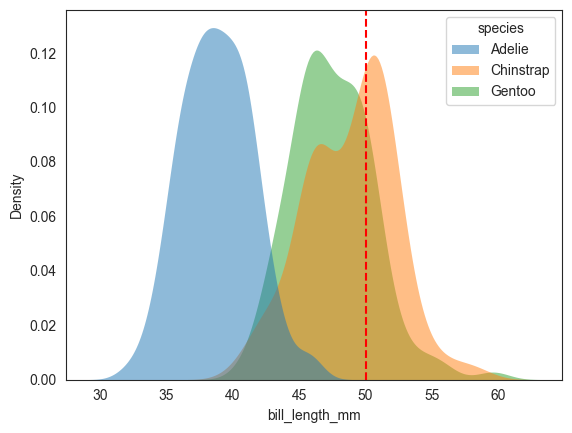

In [15]:
# plotting both distibutions on the same figure
x2 = 50
_ = sns.kdeplot(
    data=penguins,
    x="bill_length_mm",
    hue="species",
    fill=True,
    common_norm=False,
    alpha=0.5,
    linewidth=0,
    legend=True,
)
# plot vertical line
_ = plt.axvline(x2, color="r", linestyle="--", label="50 mm")
# plt.legend()
plt.show();

Before we move on, some EDA on the joint distribution of $X_2$ and $Y$. 
Note very carefully that this is a **joint distribution** of $X_2$ and $Y$, not a **conditional distribution** of $X_2$ given $Y$. 

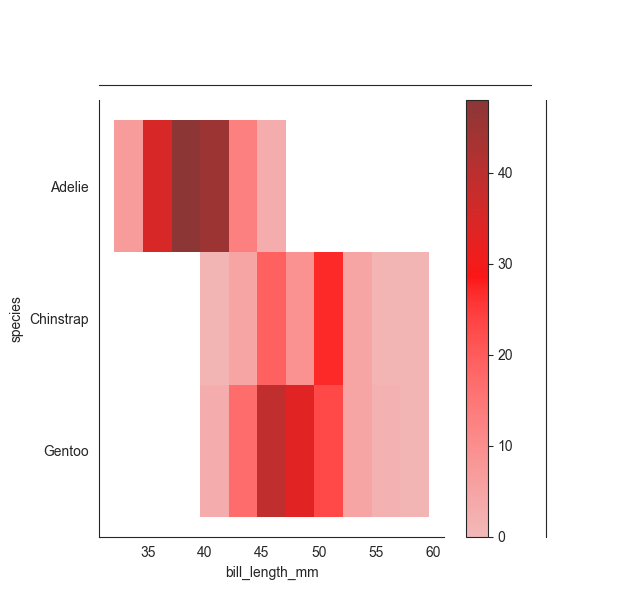

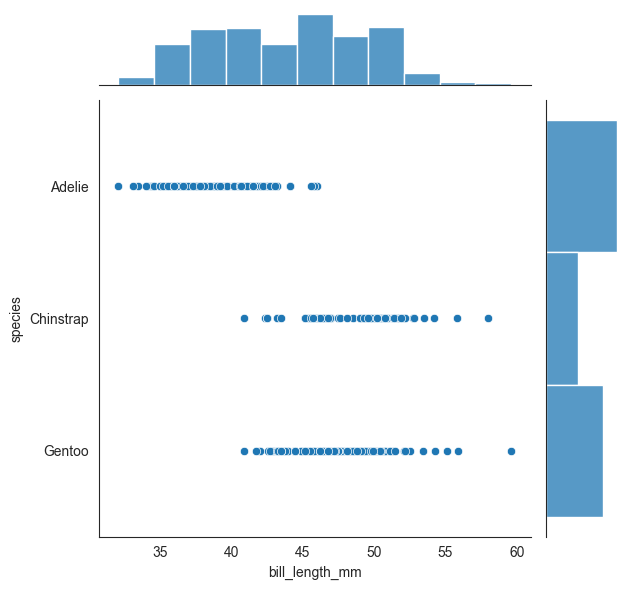

In [29]:
g = sns.JointGrid(data=penguins, x="bill_length_mm", y="species")
g.plot_joint(sns.histplot, color = "red", cbar=True)

sns.jointplot(data=penguins, x="bill_length_mm", y="species")

We see that the for this penguin with `bill_length_mm` of 50mm, our gut feeling tells us
that it most likely is not an Adelie, since the distribution of $X_2$ for Adelie is
much less than 50 mm. It could be a Chinstrap or a Gentoo, but we are not sure which one,
though Chinstrap is tends to be longer for bill length, but the earlier section has 
told us that we should weigh the prior probability of each species into consideration.

We can again use Bayes' rule to compute the posterior probability of $Y=A$ given $X_2=50$,

$$
\begin{aligned}
\mathbb{P}[Y=y|X_2=x_2] = \frac{\mathbb{P}[X_2=x_2|Y=y] \mathbb{P}[Y=y]}{\mathbb{P}[X_2=x_2]}
\end{aligned}
$$

For example, since our given feature is `bill_length_mm` of 50mm, we see

$$ 
\begin{aligned}
\mathbb{P}[Y=A|X_2=50] &= \dfrac{\mathbb{P}[X_2=50|Y=A] \mathbb{P}[Y=A]}{\mathbb{P}[X_2=50]} \\
\mathbb{P}[Y=C|X_2=50] &= \dfrac{\mathbb{P}[X_2=50|Y=C] \mathbb{P}[Y=C]}{\mathbb{P}[X_2=50]} \\
\mathbb{P}[Y=G|X_2=50] &= \dfrac{\mathbb{P}[X_2=50|Y=G] \mathbb{P}[Y=G]}{\mathbb{P}[X_2=50]}
\end{aligned}
$$

Again, we use argmax to solve the problem,

$$
\begin{aligned}
\text{argmax}_{y \in \{A, C, G\}} \mathbb{P}[Y=y|X_2=50] &= \text{argmax}_{y \in \{A, C, G\}} \dfrac{\mathbb{P}[X_2=50|Y=y] \mathbb{P}[Y=y]}{\mathbb{P}[X_2=50]} \\
&= \text{argmax}_{y \in \{A, C, G\}} \dfrac{\mathbb{P}[X_2=50|Y=y] \mathbb{P}[Y=y]}{\sum_{y' \in \{A, C, G\}} \mathbb{P}[X_2=50|Y=y'] \mathbb{P}[Y=y']}
\end{aligned}
$$



Now we met our first hurdle here since $\mathbb{P}[X_2=50|Y=y]$ is not easy to compute since
$X_2$ is a continuous variable, we cannot construct a empirical joint distribution table like
how we did earlier (`species` vs `bill_length_mm` does not work here).

Further, we haven't assumed a model for $X_2$ yet from which to define the likelihood $\mathbb{P}[X_2=50|Y=y]$ or $\mathcal{L}(X_2=50|Y=y)$. We can do like previously to assume **naively (pun intended)** that the distribution of $X_2$ **GIVEN Y** is Gaussian, note carefully
that this is a **conditional distribution** of $X_2$ given $Y$, we can also say in same
term that $X_2$ is **continuous** and **conditionally normal**.

$$
\begin{aligned}
X_2 \mid Y=A \sim \mathcal{N}(\mu_A, \sigma_A^2) \\
X_2 \mid Y=C \sim \mathcal{N}(\mu_C, \sigma_C^2) \\
X_2 \mid Y=G \sim \mathcal{N}(\mu_G, \sigma_G^2)
\end{aligned}
$$

Notice here that it is possible that the three conditional distributions are different with
different $\mu$ and $\sigma$. Technically, we can even assume that the three conditional
distributions come from different families, but we will stick to the Gaussian family for now.
We usually call this the **Gaussian Naive Bayes** model.

Intuitively, we can see that the three species are not well separated in the joint distribution space, so we cannot expect a good performance from the Gaussian Naive Bayes model. For example,
50 mm could well be either Gentoo or Chinstrap. (This understanding may be wrong?) In any case,
in our example, the conditional distribution of $X_2$ given $Y$ appears quite Gaussian.
Even if not so, the Central Limit Theorem tells us that the sum of many independent random
variables tends to be Gaussian, so we can still use the Gaussian Naive Bayes model 
if we have enough data (?).

The next question is how do we estimate the $\mu$ and $\sigma$ for each $X_2$ given $Y$?
We can use the **Maximum Likelihood Estimation** (MLE) method to estimate the parameters (clarify
whether it is MLE of MAP?)

It turns out that the MLE of $\mu$ and $\sigma$ for each $X_2$ given $Y$ is the sample mean
and sample standard deviation of $X_2$ given $Y$. They are unbiased estimators of the true
$\mu$ and $\sigma$! (**FILL In the blanks for the categorical part on Binomial and multinomial**)

MULTINOMIAL DISTRIBUTIO!

- prior is low but likelihood is high, so posterior may not be high if prior << likelihood
- Normalizing constant. argmax so it does not matter if output is probability? because for an image vector input of a certain x = [1,2,3] for eg, the P(Y=k|x) for Y = 0, 1, 2,...9 for that image are fixed at the given x, and as a result we need to compare the p(y|x) for diff y and see which is highest value. MOreover, it says that in D2L the sum of p(y|x) over y is 1, so we can cross multiply anwyays to get?
    - Furthermore, $P(X_i=x_i)$ is constant during argmax comparison, see 14.1.1 and 14.1.2 in bayes rules book, denominator is rules of total probability, so it is constant.
- Key is estimating , like P(y) we dk population! but estimate from samples, so MLE tells us that indeed 
the best estimate is derived from the sample mean. Same for the mean of the conditional distribution.

conditionally normal means within each class, the data is normal. reasonable assumption because of central limit theorem.

- Plotting the tuned Normal models for each species confirms that this naive Bayes assumption isn’t perfect – it’s a bit more idealistic than the density plots of the raw data in Figure 14.2. But it’s fine enough to continue. THIS IS BECAUSE THE ORIGINAL DATA IS NOT EXACTLY NORMAL, BUT THE CONDITIONAL NORMAL ASSUMPTION IS GOOD ENOUGH TO CONTINUE.
- Note only assumption of Naive Bayes is the random variables within xn are independent conditional on the class of observation.

- The plot below is the 1-d empirical distribution of `bill_length_mm` for all species.
- The vertical red line is the mean of the empirical distribution.
- This is where one “naive” part of naive Bayes classification comes into play. The naive Bayes method typically assumes that any quantitative predictor, here `X_2 = bill_length_mm`
    is continuous and conditionally Normal.

**Important**

From sklearn: and we can use Maximum A Posteriori (MAP) estimation to estimate $P(y)$  and $P(x_i|y)$ ; the former is then the relative frequency of class y in the training set.

The different naive Bayes classifiers differ mainly by the assumptions they make regarding the distribution of $P(x_i|y)$.

page 475 of chans book says that sample mean of the normal distribution coincides when you use MLE to estimate the mean parameter of the normal distribution.
In other words, if $X_2 | Y = A \sim N(\mu_{A}, \sigma_{A}^2)$, then to find the $P(X_2 | Y = A)$, which is the probability of $X_2=x_2$ given $Y=A$,
we know that conditional PDF is about $X_2$ as $Y$ is fixed, so we need the parameters $\mu_{A}$ and $\sigma_{A}^2$ to find the PDF.  

So this is an inverse problem of finding the parameters $\mu_{A}$ and $\sigma_{A}^2$. 
A bit confused see chans page 469, but overall, the idea is that we want to find the parameters of the normal distribution that best fit the data.
And we use MLE to find the parameters of the normal distribution that best fit the data. It turns the parameters
found through MLE are the sample mean and sample variance of the data.

Penguin with bill length of 50mm.


$P(x_2=50|y=Adelie)$

In [20]:
# plot conditional distribution of bill length given species



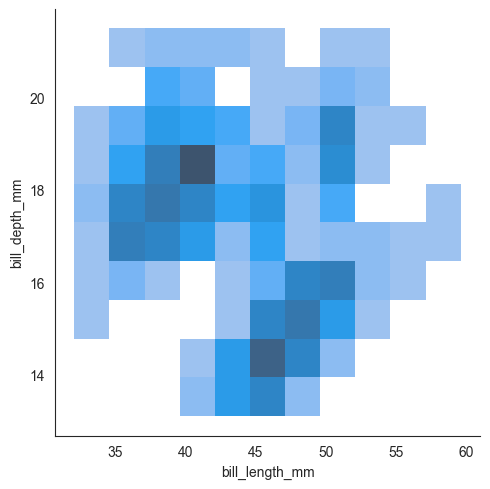

In [21]:
sns.displot(penguins, x="bill_length_mm", y="bill_depth_mm")

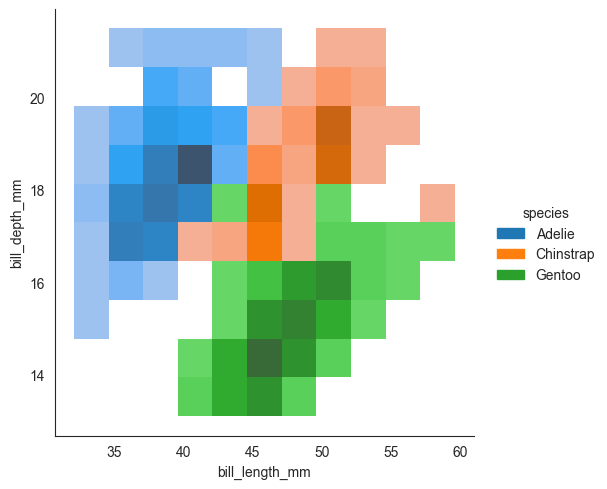

In [22]:
sns.displot(penguins, x="bill_length_mm", y="bill_depth_mm", hue="species")

## Plotting joint and marginal distributions

The first is jointplot(), which augments a bivariate relatonal or distribution plot with the marginal distributions of the two variables. By default, jointplot() represents the bivariate distribution using scatterplot() and the marginal distributions using histplot():

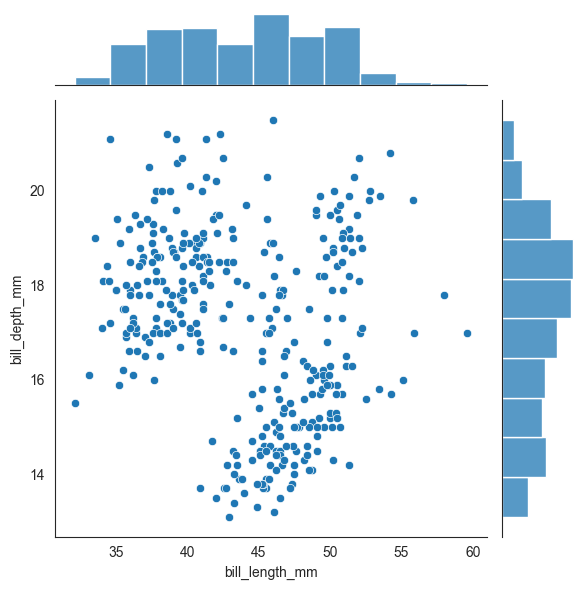

In [23]:
sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm")

In [24]:
# ax = sns.histplot(x = df['class'], hue=df['survived'], multiple="dodge", 
#                   stat = 'density', shrink = 0.8, common_norm=False)

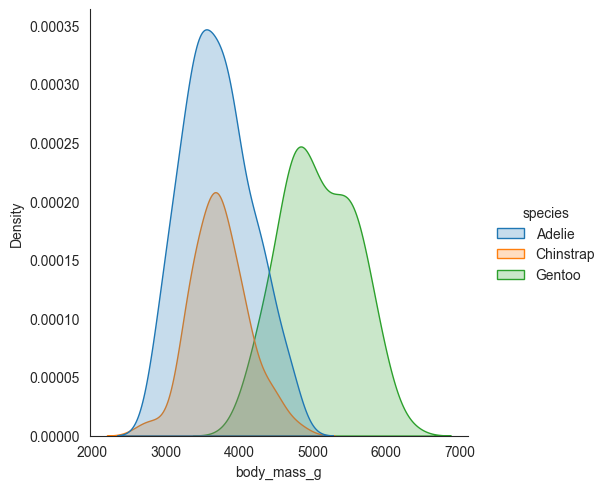

In [25]:
sns.displot(data=penguins, x="body_mass_g", hue="species", kind="kde", fill=True)

## 2 Features + 1 Class Plots

In [ ]:
g = sns.JointGrid(data=penguins, x="bill_length_mm", y="bill_depth_mm")

In [30]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,overweight
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,0
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,0
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0
...,...,...,...,...,...,...,...
337,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,1
338,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,1
339,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,1
340,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,1
